# Tugas Akhir Data Engineering Kelompok 1

---

Anggota:



1.   Dimas Agung Gumelar	195150201111032
2.   M Hafidh Ilmi Nafi’an	195150200111042
3.   Lutfi	Mitra Tanjung		195150220111001

## 1) Dataset & ETL

Dataset yang digunakan diperoleh dari stream data Twitter menggunakan API

### Instalasi Kafka

In [ ]:
!pip install kafka-python

     |████████████████████████████████| 246 kB 7.4 MB/s 


In [ ]:
!curl -sSOL https://downloads.apache.org/kafka/2.7.2/kafka_2.13-2.7.2.tgz
!tar -xzf kafka_2.13-2.7.2.tgz

In [ ]:
!./kafka_2.13-2.7.2/bin/zookeeper-server-start.sh -daemon ./kafka_2.13-2.7.2/config/zookeeper.properties
!./kafka_2.13-2.7.2/bin/kafka-server-start.sh -daemon ./kafka_2.13-2.7.2/config/server.properties
!echo "Waiting for 10 secs until kafka and zookeeper services are up and running"
!sleep 10


Waiting for 10 secs until kafka and zookeeper services are up and running


In [ ]:
!ps -ef | grep kafka

root         475       1 21 09:23 ?        00:00:02 java -Xmx512M -Xms512M -server -XX:+UseG1GC -XX:MaxGCPauseMillis=20 -XX:InitiatingHeapOccupancyPercent=35 -XX:+ExplicitGCInvokesConcurrent -XX:MaxInlineLevel=15 -Djava.awt.headless=true -Xlog:gc*:file=/content/kafka_2.13-2.7.2/bin/../logs/zookeeper-gc.log:time,tags:filecount=10,filesize=100M -Dcom.sun.management.jmxremote -Dcom.sun.management.jmxremote.authenticate=false -Dcom.sun.management.jmxremote.ssl=false -Dkafka.logs.dir=/content/kafka_2.13-2.7.2/bin/../logs -Dlog4j.configuration=file:./kafka_2.13-2.7.2/bin/../config/log4j.properties -cp /content/kafka_2.13-2.7.2/bin/../libs/activation-1.1.1.jar:/content/kafka_2.13-2.7.2/bin/../libs/aopalliance-repackaged-2.6.1.jar:/content/kafka_2.13-2.7.2/bin/../libs/argparse4j-0.7.0.jar:/content/kafka_2.13-2.7.2/bin/../libs/audience-annotations-0.5.0.jar:/content/kafka_2.13-2.7.2/bin/../libs/commons-cli-1.4.jar:/content/kafka_2.13-2.7.2/bin/../libs/commons-lang3-3.8.1.jar:/content/kafka_2.13

In [ ]:
!./kafka_2.13-2.7.2/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 1 --topic topik-wsbk-mandalika

Created topic topik-wsbk-mandalika.


In [ ]:
!./kafka_2.13-2.7.2/bin/kafka-topics.sh --describe --bootstrap-server 127.0.0.1:9092 --topic topik-wsbk-mandalika


Topic: topik-wsbk-mandalika	PartitionCount: 1	ReplicationFactor: 1	Configs: segment.bytes=1073741824
	Topic: topik-wsbk-mandalika	Partition: 0	Leader: 0	Replicas: 0	Isr: 0


### Stream, Penyesuaian Schema, Data Preprocessing

In [ ]:
# utilities
import re
import sys
import os
import tweepy
from tweepy import OAuthHandler
import numpy as np
import pandas as pd
from textblob import TextBlob
# kafka
from kafka import KafkaProducer
from datetime import datetime, timedelta
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
consumer_key = "*consumer key from twitter developer*"
consumer_secret = "*consumer secret from from twitter developer*"
access_token = "*access token from twitter developer*"
access_token_secret = "access token secret from twitter developer*"

#setup autentikasi
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# Instansiasi Kafka Producer
producer = KafkaProducer(bootstrap_servers=["127.0.0.1:9092"],api_version=(0,10,0))
topic_name = 'topik-wsbk-mandalika'

#instansiasi API
api = tweepy.API(auth, wait_on_rate_limit=True)

searchQuery = 'WSBK Mandalika' 
maxTweets = 5000 
Filter_Retweets = True 

tweetsPerQuery = 100  # this is the max the API permits

if Filter_Retweets:
  searchQuery = searchQuery + ' -filter:retweets'  # to exclude retweets

# Jika hasil dari ID tertentu dan seterusnya adalah reqd, set Since_id ke ID itu.
# lain default ke tidak ada batas bawah, kembali sejauh API memungkinkan
sinceId = None

# Jika hasil hanya di bawah ID tertentu, setel max_id ke ID itu.
# else default ke tidak ada batas atas, mulai dari tweet terbaru yang cocok dengan permintaan pencarian.
max_id = -10000000000

tweetCount = 0
print("Downloading max {0} tweets".format(maxTweets))

while tweetCount < maxTweets:
    try:
        if (max_id <= 0):
            if (not sinceId):
                new_tweets = api.search(q=searchQuery, count=tweetsPerQuery, lang="id")
            else:
                new_tweets = api.search(q=searchQuery, count=tweetsPerQuery,
                                        lang="id", since_id=sinceId)
        else:
            if (not sinceId):
                new_tweets = api.search(q=searchQuery, count=tweetsPerQuery,
                                        lang="id", max_id=str(max_id - 1))
            else:
                new_tweets = api.search(q=searchQuery, count=tweetsPerQuery,
                                        lang="id", max_id=str(max_id - 1),
                                        since_id=sinceId)
        
        if not new_tweets:
            print("No more tweets found")
            break

        for tweet in new_tweets:
          if hasattr(tweet, 'reply_count'):
            reply_count = tweet.reply_count
          else:
            reply_count = 0
          if hasattr(tweet, 'retweeted'):
            retweeted = tweet.retweeted
          else:
            retweeted = "NA"
            
          # fixup search query to get topic
          topic = searchQuery[:searchQuery.find('-')].capitalize().strip()
          
          # fixup date
          tweetDate = tweet.created_at.date()
                    
          # Send data to topic (Kafka)
          record = ";".join([str(tweetDate), topic, str(tweet.id), tweet.user.screen_name, 
                             tweet.user.name, tweet.text, str(tweet.favorite_count), 
                             str(reply_count), str(tweet.retweet_count), str(retweeted)])
          producer.send(topic_name, str.encode(record))

        tweetCount += len(new_tweets)
        print("Downloaded {0} tweets".format(tweetCount))
        max_id = new_tweets[-1].id

    except tweepy.TweepError as e:
        # Just exit if any error
        print("some error : " + str(e))
        break

print("Downloaded {0} tweets".format(tweetCount))

Downloaded 75 tweets
No more tweets found
Downloaded 75 tweets


### Load data ke DB SQLite dari Consumer Kafka

In [ ]:
import csv
from kafka import KafkaConsumer  

bootstrap_servers = ['127.0.01:9092'] 
consumer_kafka = KafkaConsumer(bootstrap_servers=bootstrap_servers, auto_offset_reset='earliest',consumer_timeout_ms=10000) 
consumer_kafka.subscribe(['topik-wsbk-mandalika'])

with open('wsbk.csv', mode='w') as wsbk:
  wsbk_writer = csv.writer(wsbk, delimiter=';', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  for message in consumer_kafka:
    if len(message) > 0:
      data = message[6].decode('utf-8').replace('\n','').split(";")
      wsbk_writer.writerow([data[0],data[1],data[2],data[3],data[4],data[5],data[6],data[7],data[8],data[9]])    

In [ ]:
import pandas as pd

datatweet = pd.read_csv('/content/wsbk.csv', names=['tanggal','topic','id','username', 'name', 'tweet', 'like_count', 'reply_count', 'retweet_count', 'retweeted'],delimiter=';')
datatweet.head()

,tanggal,topic,id,username,name,tweet,like_count,reply_count,retweet_count,retweeted
0,2021-12-22,Wsbk mandalika,1473481753763336194,Lombokitacom,LOMBOKita,"Sosok Man, Bocah Penjual Gelang yang Diviralka...",0,0,0,False
1,2021-12-22,Wsbk mandalika,1473477274108194817,IDNTimesNTB,IDN Times NTB,"Diberi sertifikat, tetapi tak diberi kejelasan...",1,0,3,False
2,2021-12-21,Wsbk mandalika,1473438168930078720,randhilicious,Dhika...,@Raffandy12 emang lo mampu nyet bayar ongkos p...,0,0,0,False
3,2021-12-21,Wsbk mandalika,1473437467428589568,randhilicious,Dhika...,"@NebhukadNezhar betul nyet, gue kalo lagi buru...",0,0,0,False
4,2021-12-21,Wsbk mandalika,1473436619264851973,randhilicious,Dhika...,@MieAyamSerang lo udah ke nonton WSBK mandalik...,0,0,0,False


In [ ]:
import sqlite3

conn = sqlite3.connect('wsbk.db')
print("Database berhasil dibuka")

conn.execute('''
CREATE TABLE IF NOT EXISTS mandalika(tanggal text,
                                topic text,
                                id text,
                                username text,
                                name text,
                                tweet text,
                                like_count text,
                                reply_count text,
                                retweeted_count text,
                                retweeted text);''')
conn.commit()
print("Tabel berhasil dibuat")

conn.close()

Database berhasil dibuka
Tabel berhasil dibuat


In [ ]:
import csv

conn = sqlite3.connect('wsbk.db')
cursor = conn.cursor()

no_records = 0

for i in range(datatweet.shape[0]):
  cursor.execute("INSERT INTO mandalika VALUES(?,?,?,?,?,?,?,?,?,?)", 
                 [datatweet['tanggal'][i],
                 datatweet['topic'][i],
                 str(datatweet['id'][i]),
                 datatweet['username'][i],
                 datatweet['name'][i],
                 datatweet['tweet'][i],
                 str(datatweet['like_count'][i]),
                 str(datatweet['reply_count'][i]),
                 str(datatweet['retweet_count'][i]),
                 str(datatweet['retweeted'][i])])
  conn.commit()
  no_records += 1

conn.close()
print('\n{} Record dimasukkan'.format(no_records))


75 Record dimasukkan


### Ambil Subset Data dari DB

In [ ]:
conn = sqlite3.connect('wsbk.db')
cursor = conn.cursor()
tweets = cursor.execute("SELECT * FROM mandalika LIMIT 10")

for tweet in tweets:
  print(tweet)

cursor.close()

('2021-12-22', 'Wsbk mandalika', '1473481753763336194', 'Lombokitacom', 'LOMBOKita', 'Sosok Man, Bocah Penjual Gelang yang Diviralkan Pebalap Scott Redding Saat WSBK Mandalika https://t.co/KlP3tOcYjq https://t.co/Iry892etSW', '0', '0', '0', 'False')
('2021-12-22', 'Wsbk mandalika', '1473477274108194817', 'IDNTimesNTB', 'IDN Times NTB', 'Diberi sertifikat, tetapi tak diberi kejelasan kawal MotoGP https://t.co/5qL7CAmKnD', '1', '0', '3', 'False')
('2021-12-21', 'Wsbk mandalika', '1473438168930078720', 'randhilicious', 'Dhika...', '@Raffandy12 emang lo mampu nyet bayar ongkos pesawat PP+tiket nonton WSBK mandalika? 😏😏', '0', '0', '0', 'False')
('2021-12-21', 'Wsbk mandalika', '1473437467428589568', 'randhilicious', 'Dhika...', '@NebhukadNezhar betul nyet, gue kalo lagi buru2 banget gue naik ojol. 😆btw lo udah nonton WSBK ke mandalika blm?… https://t.co/YMzHExRQ4E', '0', '0', '0', 'False')
('2021-12-21', 'Wsbk mandalika', '1473436619264851973', 'randhilicious', 'Dhika...', '@MieAyamSerang 

## 2) Exploratory Data Analysis & Machine Learning

In [ ]:
conn = sqlite3.connect('wsbk.db')
cursor = conn.cursor()
tweets = cursor.execute("SELECT * FROM mandalika")

tweet_df = pd.DataFrame(tweets, columns=['tanggal','topic','id','username', 'name', 'tweet', 'like_count', 'reply_count', 'retweet_count', 'retweeted'])

cursor.close()

In [ ]:
tweet_df.head()

,tanggal,topic,id,username,name,tweet,like_count,reply_count,retweet_count,retweeted
0,2021-12-22,Wsbk mandalika,1473481753763336194,Lombokitacom,LOMBOKita,"Sosok Man, Bocah Penjual Gelang yang Diviralka...",0,0,0,False
1,2021-12-22,Wsbk mandalika,1473477274108194817,IDNTimesNTB,IDN Times NTB,"Diberi sertifikat, tetapi tak diberi kejelasan...",1,0,3,False
2,2021-12-21,Wsbk mandalika,1473438168930078720,randhilicious,Dhika...,@Raffandy12 emang lo mampu nyet bayar ongkos p...,0,0,0,False
3,2021-12-21,Wsbk mandalika,1473437467428589568,randhilicious,Dhika...,"@NebhukadNezhar betul nyet, gue kalo lagi buru...",0,0,0,False
4,2021-12-21,Wsbk mandalika,1473436619264851973,randhilicious,Dhika...,@MieAyamSerang lo udah ke nonton WSBK mandalik...,0,0,0,False


**Model Menggunakan NER(Named Entity Recognition) --> dapat Mengenali orang dan tempat; dan Sentiment Analysis**

In [ ]:
# install Flair
!pip install --upgrade git+https://github.com/flairNLP/flair.git

  Cloning https://github.com/flairNLP/flair.git to /tmp/pip-req-build-11fwkx1i
  Running command git clone -q https://github.com/flairNLP/flair.git /tmp/pip-req-build-11fwkx1i
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 64 kB 1.6 MB/s 
     |████████████████████████████████| 788 kB 10.2 MB/s 
     |████████████████████████████████| 19.7 MB 4.4 MB/s 
     |████████████████████████████████| 48 kB 4.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 3.4 MB 49.1 MB/s 
     |████████████████████████████████| 61 kB 421 kB/s 
     |████████████████████████████████| 981 kB 49.8 MB/s 
     |████████████████████████████████| 1.2 MB 43.7 MB/s 
     |████████████████████████████████| 62 kB 701 kB/s 
     |████████████████████████████████| 596 kB 50.2 MB/s 


In [ ]:
from flair.data import Sentence
from flair.models import SequenceTagger

tagger = SequenceTagger.load('ner')

#clear_output()

Downloading:   0%|          | 0.00/432M [00:00<?, ?B/s]

2021-12-22 09:26:08,888 loading file /root/.flair/models/ner-english/4f4cdab26f24cb98b732b389e6cebc646c36f54cfd6e0b7d3b90b25656e4262f.8baa8ae8795f4df80b28e7f7b61d788ecbb057d1dc85aacb316f1bd02837a4a4


In [ ]:
#import Flair Classifier
from flair.models import TextClassifier

classifier = TextClassifier.load('en-sentiment')

2021-12-22 09:26:13,642 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmp4bmwxwkn


100%|██████████| 265512723/265512723 [00:13<00:00, 19880825.77B/s]

2021-12-22 09:26:27,368 copying /tmp/tmp4bmwxwkn to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2021-12-22 09:26:28,432 removing temp file /tmp/tmp4bmwxwkn
2021-12-22 09:26:28,523 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
tweet_df.head()

,tanggal,topic,id,username,name,tweet,like_count,reply_count,retweet_count,retweeted
0,2021-12-22,Wsbk mandalika,1473481753763336194,Lombokitacom,LOMBOKita,"Sosok Man, Bocah Penjual Gelang yang Diviralka...",0,0,0,False
1,2021-12-22,Wsbk mandalika,1473477274108194817,IDNTimesNTB,IDN Times NTB,"Diberi sertifikat, tetapi tak diberi kejelasan...",1,0,3,False
2,2021-12-21,Wsbk mandalika,1473438168930078720,randhilicious,Dhika...,@Raffandy12 emang lo mampu nyet bayar ongkos p...,0,0,0,False
3,2021-12-21,Wsbk mandalika,1473437467428589568,randhilicious,Dhika...,"@NebhukadNezhar betul nyet, gue kalo lagi buru...",0,0,0,False
4,2021-12-21,Wsbk mandalika,1473436619264851973,randhilicious,Dhika...,@MieAyamSerang lo udah ke nonton WSBK mandalik...,0,0,0,False


In [ ]:
from tqdm import tqdm
nerlst = []

for index, row in tqdm(tweet_df.iterrows(), total=tweet_df.shape[0]):
  cleanedTweet = row['tweet'].replace("#", "")
  sentence = Sentence(cleanedTweet, use_tokenizer=True)
  
  # predict NER tags
  tagger.predict(sentence)

  # get ner
  ners = sentence.to_dict(tag_type='ner')['entities']
  
  # predict sentiment
  classifier.predict(sentence)
  
  label = sentence.labels[0]
  response = {'result': label.value, 'polarity':label.score}
  
  # get hashtags
  hashtags = re.findall(r'#\w+', row['tweet'])
  if len(hashtags) >= 1:
    for hashtag in hashtags:
      ners.append({ 'type': 'Hashtag', 'text': hashtag })
  
  for ner in ners:
    adj_polarity = response['polarity']
    if response['result'] == 'NEGATIVE':
      adj_polarity = response['polarity'] * -1
    try:
      ner['type']
    except:
      ner['type'] = ''      
    nerlst.append([ row['tanggal'], row['topic'], row['id'], row['username'], 
                   row['name'], row['tweet'], ner['type'], ner['text'], response['result'], 
                   response['polarity'], adj_polarity, row['like_count'], row['reply_count'], 
                  row['retweet_count'] ])

100%|██████████| 75/75 [03:23<00:00,  2.71s/it]


In [ ]:
df_ner = pd.DataFrame(nerlst, columns=['tweet_dt', 'topic', 'id', 'username', 'name', 'tweet', 'tag_type', 'tag', 'sentiment', 'polarity', 
                                       'adj_polarity','like_count', 'reply_count', 'retweet_count'])
df_ner.head()

,tweet_dt,topic,id,username,name,tweet,tag_type,tag,sentiment,polarity,adj_polarity,like_count,reply_count,retweet_count
0,2021-12-22,Wsbk mandalika,1473481753763336194,Lombokitacom,LOMBOKita,"Sosok Man, Bocah Penjual Gelang yang Diviralka...",,Sosok Man,POSITIVE,0.789133,0.789133,0,0,0
1,2021-12-22,Wsbk mandalika,1473481753763336194,Lombokitacom,LOMBOKita,"Sosok Man, Bocah Penjual Gelang yang Diviralka...",,Bocah Penjual Gelang yang Diviralkan Pebalap S...,POSITIVE,0.789133,0.789133,0,0,0
2,2021-12-21,Wsbk mandalika,1473160091008266241,KompasTV,KOMPAS TV,"Diam-diam, Petinggi F1 Menonton WSBK di Sirkui...",,Diam-diam,NEGATIVE,0.565779,-0.565779,9,0,0
3,2021-12-21,Wsbk mandalika,1473160091008266241,KompasTV,KOMPAS TV,"Diam-diam, Petinggi F1 Menonton WSBK di Sirkui...",,Petinggi F1 Menonton WSBK di Sirkuit Mandalika,NEGATIVE,0.565779,-0.565779,9,0,0
4,2021-12-21,Wsbk mandalika,1473160091008266241,KompasTV,KOMPAS TV,"Diam-diam, Petinggi F1 Menonton WSBK di Sirkui...",,Ada Apa,NEGATIVE,0.565779,-0.565779,9,0,0


In [ ]:
df_ner['sentiment'].value_counts()

POSITIVE    127
NEGATIVE     16
Name: sentiment, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


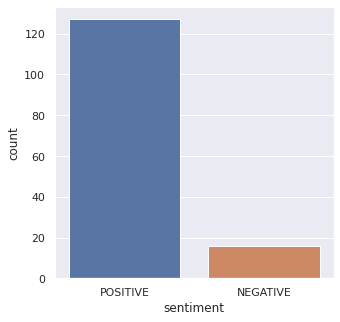

In [ ]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(5,5)})
sns.countplot('sentiment', data=df_ner)

In [ ]:
ner_groups = df_ner.groupby(['tag', 'tag_type']).agg({'tag': "count", 'adj_polarity': "mean",
                                                     'like_count': 'sum', 'reply_count': 'sum',
                                                     'retweet_count': 'sum'})
ner_groups = ner_groups.rename(columns={
    "tag": "Frequency",
    "adj_polarity": "Avg_Polarity",
    "like_count": "Total_Likes",
    "reply_count": "Total_Replies",
    "retweet_count": "Total_Retweets"
})
ner_groups = ner_groups.sort_values(['Frequency'], ascending=False)
ner_groups = ner_groups.reset_index()
ner_groups.head()

,tag,tag_type,Frequency,Avg_Polarity,Total_Likes,Total_Replies,Total_Retweets
0,WSBK di Sirkuit Mandalika,,17,0.788853,00000010100100120,00000000000000000,00000000100000010
1,Satu Keluarga Jadi Copet Internasional,,14,0.775760,00000010101120,00000000000000,00000000100010
2,MMC MillennialsUsai,,11,0.775372,00000101012,00000000000,00000001001
3,Usai kepergok,,7,0.860752,0002000,0000000,0000000
4,jejak ayah-ibu-anak,,7,0.860752,0002000,0000000,0000000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


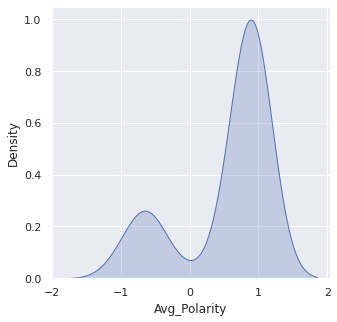

In [ ]:
sns.distplot(ner_groups['Avg_Polarity'],hist=False,kde_kws={'shade':True})

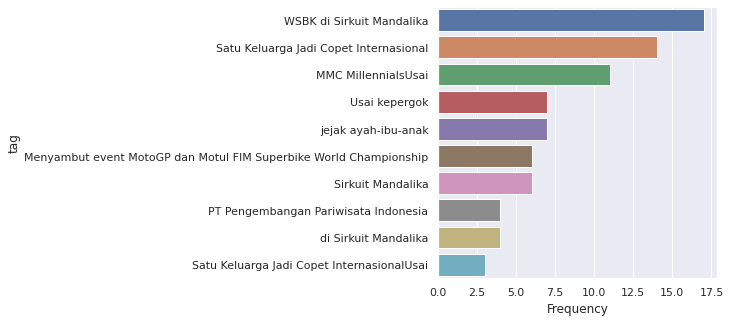

In [ ]:
sns.barplot(x='Frequency', y='tag', data=ner_groups[:10])

In [ ]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from os import path

In [ ]:
def create_wordcloud(text):
  stopwords = set(STOPWORDS)
  wc = WordCloud(background_color='white', max_words=3000,stopwords=stopwords,repeat=True)
  wc.generate(str(text))
  wc.to_file('wc.png')
  print('Word Cloud Saved Successfully')
  path='wc.png'
  display(Image.open(path))

Word Cloud Saved Successfully


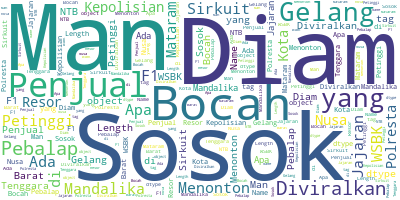

In [ ]:
create_wordcloud(df_ner['tag'])